## DRAGON *DualFinder*: An Instance of the DRAGON CNN Architecture Specialized for Dual AGN Detection.
### Authors: Isaac Moskowitz and Jeremy Ng
### Collaborators: C. Meg Urry (PI), Aritra Ghosh. 
#### Began June 7, 2024


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
import logging
import pandas as pd
import csv
import sys
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score 
from keras import backend as K
import os
from os.path import exists
from tqdm import tqdm
import glob
#import tensorflow_addons as tfa
import shutil
#from dual_finder import DualFinder, loadModelClass
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(tf.config.list_physical_devices())
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
from astropy.io import fits

sys.path.append("DRAGON_Dual_Finder/dual_finder/cnn/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/optimize/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/preprocess_data/")
sys.path.append("DRAGON_Dual_Finder/dual_finder/visualize/")
from create_cnn import ModelCreator
from load_model import loadModelClass
from train_cnn import DualFinder
from extract_feature_maps import FeatureExtractor
from fits_utils import plot_dataset_sample
from process_data import make_datasets_other_bands, create_dataset, crop_center
from optimize_hyperparameters import OptimizeHyperparameters
from visualize_performance import load_training_history, plot_training_progress, plot_grouped_training_progress, VisualizeOptimization
from inference_tests import testResults

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU is available
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 702431962637741301
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 83044597760
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1640900936999037506
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:31:00.0, compute capability: 8.0"
xla_global_id: 416903419
]


2024-06-25 16:47:18.559763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 79197 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:31:00.0, compute capability: 8.0


In [6]:
#os.chdir("~/")
#!pwd
empty_sky_filepath = "data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/"
single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
dual_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/train_data/"
offset_AGN_filepath = 'data_preprocessing/training_datasets/offset_AGN_datasets/train_data/'
stellar_filepath = "data_preprocessing/training_datasets/stellar_dataset/train_data/"
merger_filepath = "data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/"
train_data_labels, val_data_labels, test_data_labels = create_dataset(empty_sky_filepath = empty_sky_filepath,
                                                                      dual_image_filepath = dual_AGN_filepath,
                                                                      merger_filepath = merger_filepath,
                                                                      single_image_filepath = single_AGN_filepath)
train_dataset, train_labels, train_filepaths = train_data_labels
val_dataset, val_labels, val_filepaths = val_data_labels
test_dataset, test_labels, test_filepaths = test_data_labels


2024-06-25 15:10:47,363 - INFO - Loading images from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/ with label empty_sky...
100%|██████████| 9336/9336 [00:14<00:00, 639.16it/s]
9336it [00:41, 223.33it/s]
2024-06-25 15:11:45,340 - INFO - Loading images from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/ with label single_AGN...


Loaded 37344 images with 37344 labels from data_preprocessing/training_datasets/empty_space_dataset/empty_space_train_data/


100%|██████████| 2958/2958 [00:04<00:00, 698.47it/s]
2958it [00:44, 66.85it/s]
2024-06-25 15:12:35,348 - INFO - Loading images from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/ with label dual_AGN...


Loaded 32538 images with 32538 labels from data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/
Length of single AGN images: 32538


100%|██████████| 55921/55921 [01:02<00:00, 890.82it/s] 
2024-06-25 15:13:38,940 - INFO - expanding dims
2024-06-25 15:13:38,940 - INFO - Loading images from data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/ with label merger...


Loaded 55921 images with 55921 labels from data_preprocessing/training_datasets/dual_AGN_datasets/train_data/


100%|██████████| 11009/11009 [00:16<00:00, 650.81it/s]
11009it [01:06, 165.64it/s]


Loaded 55045 images with 55045 labels from data_preprocessing/training_datasets/merger_datasets/new_train_data/g_band_mergers/
Length of merger imagesL: (55045, 94, 94, 1)
Total images: (180848, 94, 94, 1)
Total labels: (180848,)
Total filepaths: (180848,)
Train_dataset: (117551, 94, 94, 1)
Train_labels: (117551,)
Train_filepaths: (117551,)
Val_dataset: (36169, 94, 94, 1)
Val_labels: (36169,)
Val_filepaths: (36169,)
Test_dataset: (27128, 94, 94, 1)
Test_labels: (27128,)
Test_filepaths: (27128,)


In [7]:
print(np.shape(val_dataset))
print(np.shape(val_labels))

(36169, 94, 94, 1)
(36169,)


In [11]:
image_shape = (94,94,1)
epoch = 20
batch_size = 64
init_learning_rate = 0.00005
num_classes = 4
model_type = 'dualfinder'
importance_score = [1.0, 1.0]

dual_finder_instance = DualFinder(train_dataset, val_dataset, image_shape, train_labels, val_labels, epoch, batch_size, init_learning_rate, num_classes, model_type, importance_score, display_architecture = True)
history, dual_finder_model = dual_finder_instance.trainCNN(dropout_rate = 0.5, save_feature_maps = False)

['empty_sky' 'dual_AGN' 'empty_sky' ... 'empty_sky' 'dual_AGN'
 'single_AGN']
['empty_sky' 'dual_AGN' 'merger' ... 'merger' 'dual_AGN' 'dual_AGN']
Converting to list
Converting to list
train_labels shape: (117551, 4)
val_labels shape: (36169, 4)
Unique train labels: [0. 1.]
Unique val labels: [0. 1.]
4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 94, 94, 1)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 94, 94, 64)        640       
                                                                 
 dropout_16 (Dropout)        (None, 94, 94, 64)        0         
                                                                 
 batch_normalization_14 (Ba  (None, 94, 94, 64)        256       
 tchNormalization)                                               
              

2024-06-25 15:50:23,560 - INFO - 'save_feature_maps' == False, NOT saving feature maps


train_images shape: (117551, 94, 94, 1)
train_labels shape: (117551, 4)
val_images shape: (36169, 94, 94, 1)
val_labels shape: (36169, 4)
Epoch 1/20


2024-06-25 15:50:27.724839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3673/3674 [============================>.] - ETA: 0s - loss: 14.1024 - accuracy: 0.8917 - precision: 0.9004 - recall: 0.8834 - f1_score: 0.8890INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 15:51:47,006 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 81s 21ms/step - loss: 14.1012 - accuracy: 0.8917 - precision: 0.9005 - recall: 0.8834 - f1_score: 0.8890 - val_loss: 6.3349 - val_accuracy: 0.7248 - val_precision: 0.7263 - val_recall: 0.7238 - val_f1_score: 0.7238
Epoch 2/20
3673/3674 [============================>.] - ETA: 0s - loss: 2.9137 - accuracy: 0.9352 - precision: 0.9374 - recall: 0.9335 - f1_score: 0.9335INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 15:53:03,737 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 77s 21ms/step - loss: 2.9135 - accuracy: 0.9352 - precision: 0.9374 - recall: 0.9335 - f1_score: 0.9335 - val_loss: 1.6859 - val_accuracy: 0.9108 - val_precision: 0.9128 - val_recall: 0.9088 - val_f1_score: 0.9088
Epoch 3/20
3673/3674 [============================>.] - ETA: 0s - loss: 1.0316 - accuracy: 0.9430 - precision: 0.9447 - recall: 0.9415 - f1_score: 0.9417INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 15:54:20,103 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 1.0315 - accuracy: 0.9430 - precision: 0.9447 - recall: 0.9415 - f1_score: 0.9417 - val_loss: 0.6973 - val_accuracy: 0.9536 - val_precision: 0.9560 - val_recall: 0.9511 - val_f1_score: 0.9524
Epoch 4/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.5948 - accuracy: 0.9492 - precision: 0.9510 - recall: 0.9478 - f1_score: 0.9480INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 15:55:36,450 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.5948 - accuracy: 0.9492 - precision: 0.9510 - recall: 0.9478 - f1_score: 0.9480 - val_loss: 0.5748 - val_accuracy: 0.9451 - val_precision: 0.9474 - val_recall: 0.9425 - val_f1_score: 0.9452
Epoch 5/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.4660 - accuracy: 0.9540 - precision: 0.9559 - recall: 0.9521 - f1_score: 0.9530INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 15:56:53,166 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 77s 21ms/step - loss: 0.4660 - accuracy: 0.9540 - precision: 0.9559 - recall: 0.9521 - f1_score: 0.9530 - val_loss: 0.4669 - val_accuracy: 0.9336 - val_precision: 0.9406 - val_recall: 0.9274 - val_f1_score: 0.9325
Epoch 6/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.3905 - accuracy: 0.9563 - precision: 0.9585 - recall: 0.9545 - f1_score: 0.9553INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 15:58:09,471 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.3905 - accuracy: 0.9563 - precision: 0.9585 - recall: 0.9545 - f1_score: 0.9552 - val_loss: 0.5917 - val_accuracy: 0.9103 - val_precision: 0.9111 - val_recall: 0.9097 - val_f1_score: 0.9084
Epoch 7/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.3459 - accuracy: 0.9591 - precision: 0.9611 - recall: 0.9573 - f1_score: 0.9580INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 15:59:26,121 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 77s 21ms/step - loss: 0.3458 - accuracy: 0.9591 - precision: 0.9611 - recall: 0.9573 - f1_score: 0.9580 - val_loss: 0.4055 - val_accuracy: 0.9361 - val_precision: 0.9395 - val_recall: 0.9314 - val_f1_score: 0.9344
Epoch 8/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.9604 - precision: 0.9622 - recall: 0.9585 - f1_score: 0.9593INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:00:42,527 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.3212 - accuracy: 0.9604 - precision: 0.9622 - recall: 0.9585 - f1_score: 0.9593 - val_loss: 0.4117 - val_accuracy: 0.9395 - val_precision: 0.9420 - val_recall: 0.9368 - val_f1_score: 0.9374
Epoch 9/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.9627 - precision: 0.9646 - recall: 0.9609 - f1_score: 0.9618INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:01:59,216 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 77s 21ms/step - loss: 0.2924 - accuracy: 0.9627 - precision: 0.9647 - recall: 0.9609 - f1_score: 0.9618 - val_loss: 0.4197 - val_accuracy: 0.9247 - val_precision: 0.9431 - val_recall: 0.8956 - val_f1_score: 0.9196
Epoch 10/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2763 - accuracy: 0.9633 - precision: 0.9651 - recall: 0.9616 - f1_score: 0.9622INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:03:15,588 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.2763 - accuracy: 0.9633 - precision: 0.9651 - recall: 0.9616 - f1_score: 0.9622 - val_loss: 0.2525 - val_accuracy: 0.9706 - val_precision: 0.9731 - val_recall: 0.9685 - val_f1_score: 0.9696
Epoch 11/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.9637 - precision: 0.9656 - recall: 0.9620 - f1_score: 0.9628INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:04:31,884 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.2694 - accuracy: 0.9637 - precision: 0.9656 - recall: 0.9620 - f1_score: 0.9628 - val_loss: 0.2910 - val_accuracy: 0.9562 - val_precision: 0.9585 - val_recall: 0.9537 - val_f1_score: 0.9546
Epoch 12/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2512 - accuracy: 0.9652 - precision: 0.9670 - recall: 0.9637 - f1_score: 0.9643INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:05:48,803 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 77s 21ms/step - loss: 0.2512 - accuracy: 0.9652 - precision: 0.9670 - recall: 0.9637 - f1_score: 0.9643 - val_loss: 0.6043 - val_accuracy: 0.8453 - val_precision: 0.8504 - val_recall: 0.8395 - val_f1_score: 0.8442
Epoch 13/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2425 - accuracy: 0.9661 - precision: 0.9678 - recall: 0.9647 - f1_score: 0.9651INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:07:05,141 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.2425 - accuracy: 0.9661 - precision: 0.9678 - recall: 0.9647 - f1_score: 0.9651 - val_loss: 0.6748 - val_accuracy: 0.7588 - val_precision: 0.7663 - val_recall: 0.7494 - val_f1_score: 0.6548
Epoch 14/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2475 - accuracy: 0.9654 - precision: 0.9673 - recall: 0.9637 - f1_score: 0.9645INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:08:21,847 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 77s 21ms/step - loss: 0.2475 - accuracy: 0.9654 - precision: 0.9673 - recall: 0.9637 - f1_score: 0.9645 - val_loss: 0.4326 - val_accuracy: 0.9043 - val_precision: 0.9082 - val_recall: 0.9002 - val_f1_score: 0.9010
Epoch 15/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9680 - precision: 0.9696 - recall: 0.9666 - f1_score: 0.9671INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:09:38,211 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.2221 - accuracy: 0.9680 - precision: 0.9696 - recall: 0.9667 - f1_score: 0.9671 - val_loss: 0.4727 - val_accuracy: 0.7848 - val_precision: 0.7885 - val_recall: 0.7834 - val_f1_score: 0.6813
Epoch 16/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9681 - precision: 0.9697 - recall: 0.9666 - f1_score: 0.9671INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:10:54,508 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.2213 - accuracy: 0.9681 - precision: 0.9697 - recall: 0.9666 - f1_score: 0.9671 - val_loss: 0.7062 - val_accuracy: 0.9054 - val_precision: 0.9405 - val_recall: 0.7637 - val_f1_score: 0.9024
Epoch 17/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9688 - precision: 0.9706 - recall: 0.9672 - f1_score: 0.9679INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:12:11,265 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 77s 21ms/step - loss: 0.2144 - accuracy: 0.9688 - precision: 0.9706 - recall: 0.9672 - f1_score: 0.9679 - val_loss: 0.7259 - val_accuracy: 0.8440 - val_precision: 0.8555 - val_recall: 0.8361 - val_f1_score: 0.8375
Epoch 18/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9698 - precision: 0.9713 - recall: 0.9683 - f1_score: 0.9689INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:13:27,613 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.2056 - accuracy: 0.9698 - precision: 0.9713 - recall: 0.9683 - f1_score: 0.9689 - val_loss: 0.4055 - val_accuracy: 0.9140 - val_precision: 0.9179 - val_recall: 0.9099 - val_f1_score: 0.9108
Epoch 19/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9701 - precision: 0.9714 - recall: 0.9688 - f1_score: 0.9692INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:14:44,260 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 77s 21ms/step - loss: 0.2025 - accuracy: 0.9701 - precision: 0.9714 - recall: 0.9688 - f1_score: 0.9692 - val_loss: 0.6127 - val_accuracy: 0.7562 - val_precision: 0.7572 - val_recall: 0.7537 - val_f1_score: 0.6518
Epoch 20/20
3673/3674 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9710 - precision: 0.9725 - recall: 0.9697 - f1_score: 0.9701INFO:tensorflow:Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


2024-06-25 16:16:00,657 - INFO - Assets written to: ../saved_dual_finder_models/_checkpoint_training/assets


3674/3674 [==============================] - 76s 21ms/step - loss: 0.1941 - accuracy: 0.9710 - precision: 0.9725 - recall: 0.9696 - f1_score: 0.9701 - val_loss: 0.5690 - val_accuracy: 0.8667 - val_precision: 0.8785 - val_recall: 0.8588 - val_f1_score: 0.8724


/home/iam37/.conda/envs/DualFinder/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


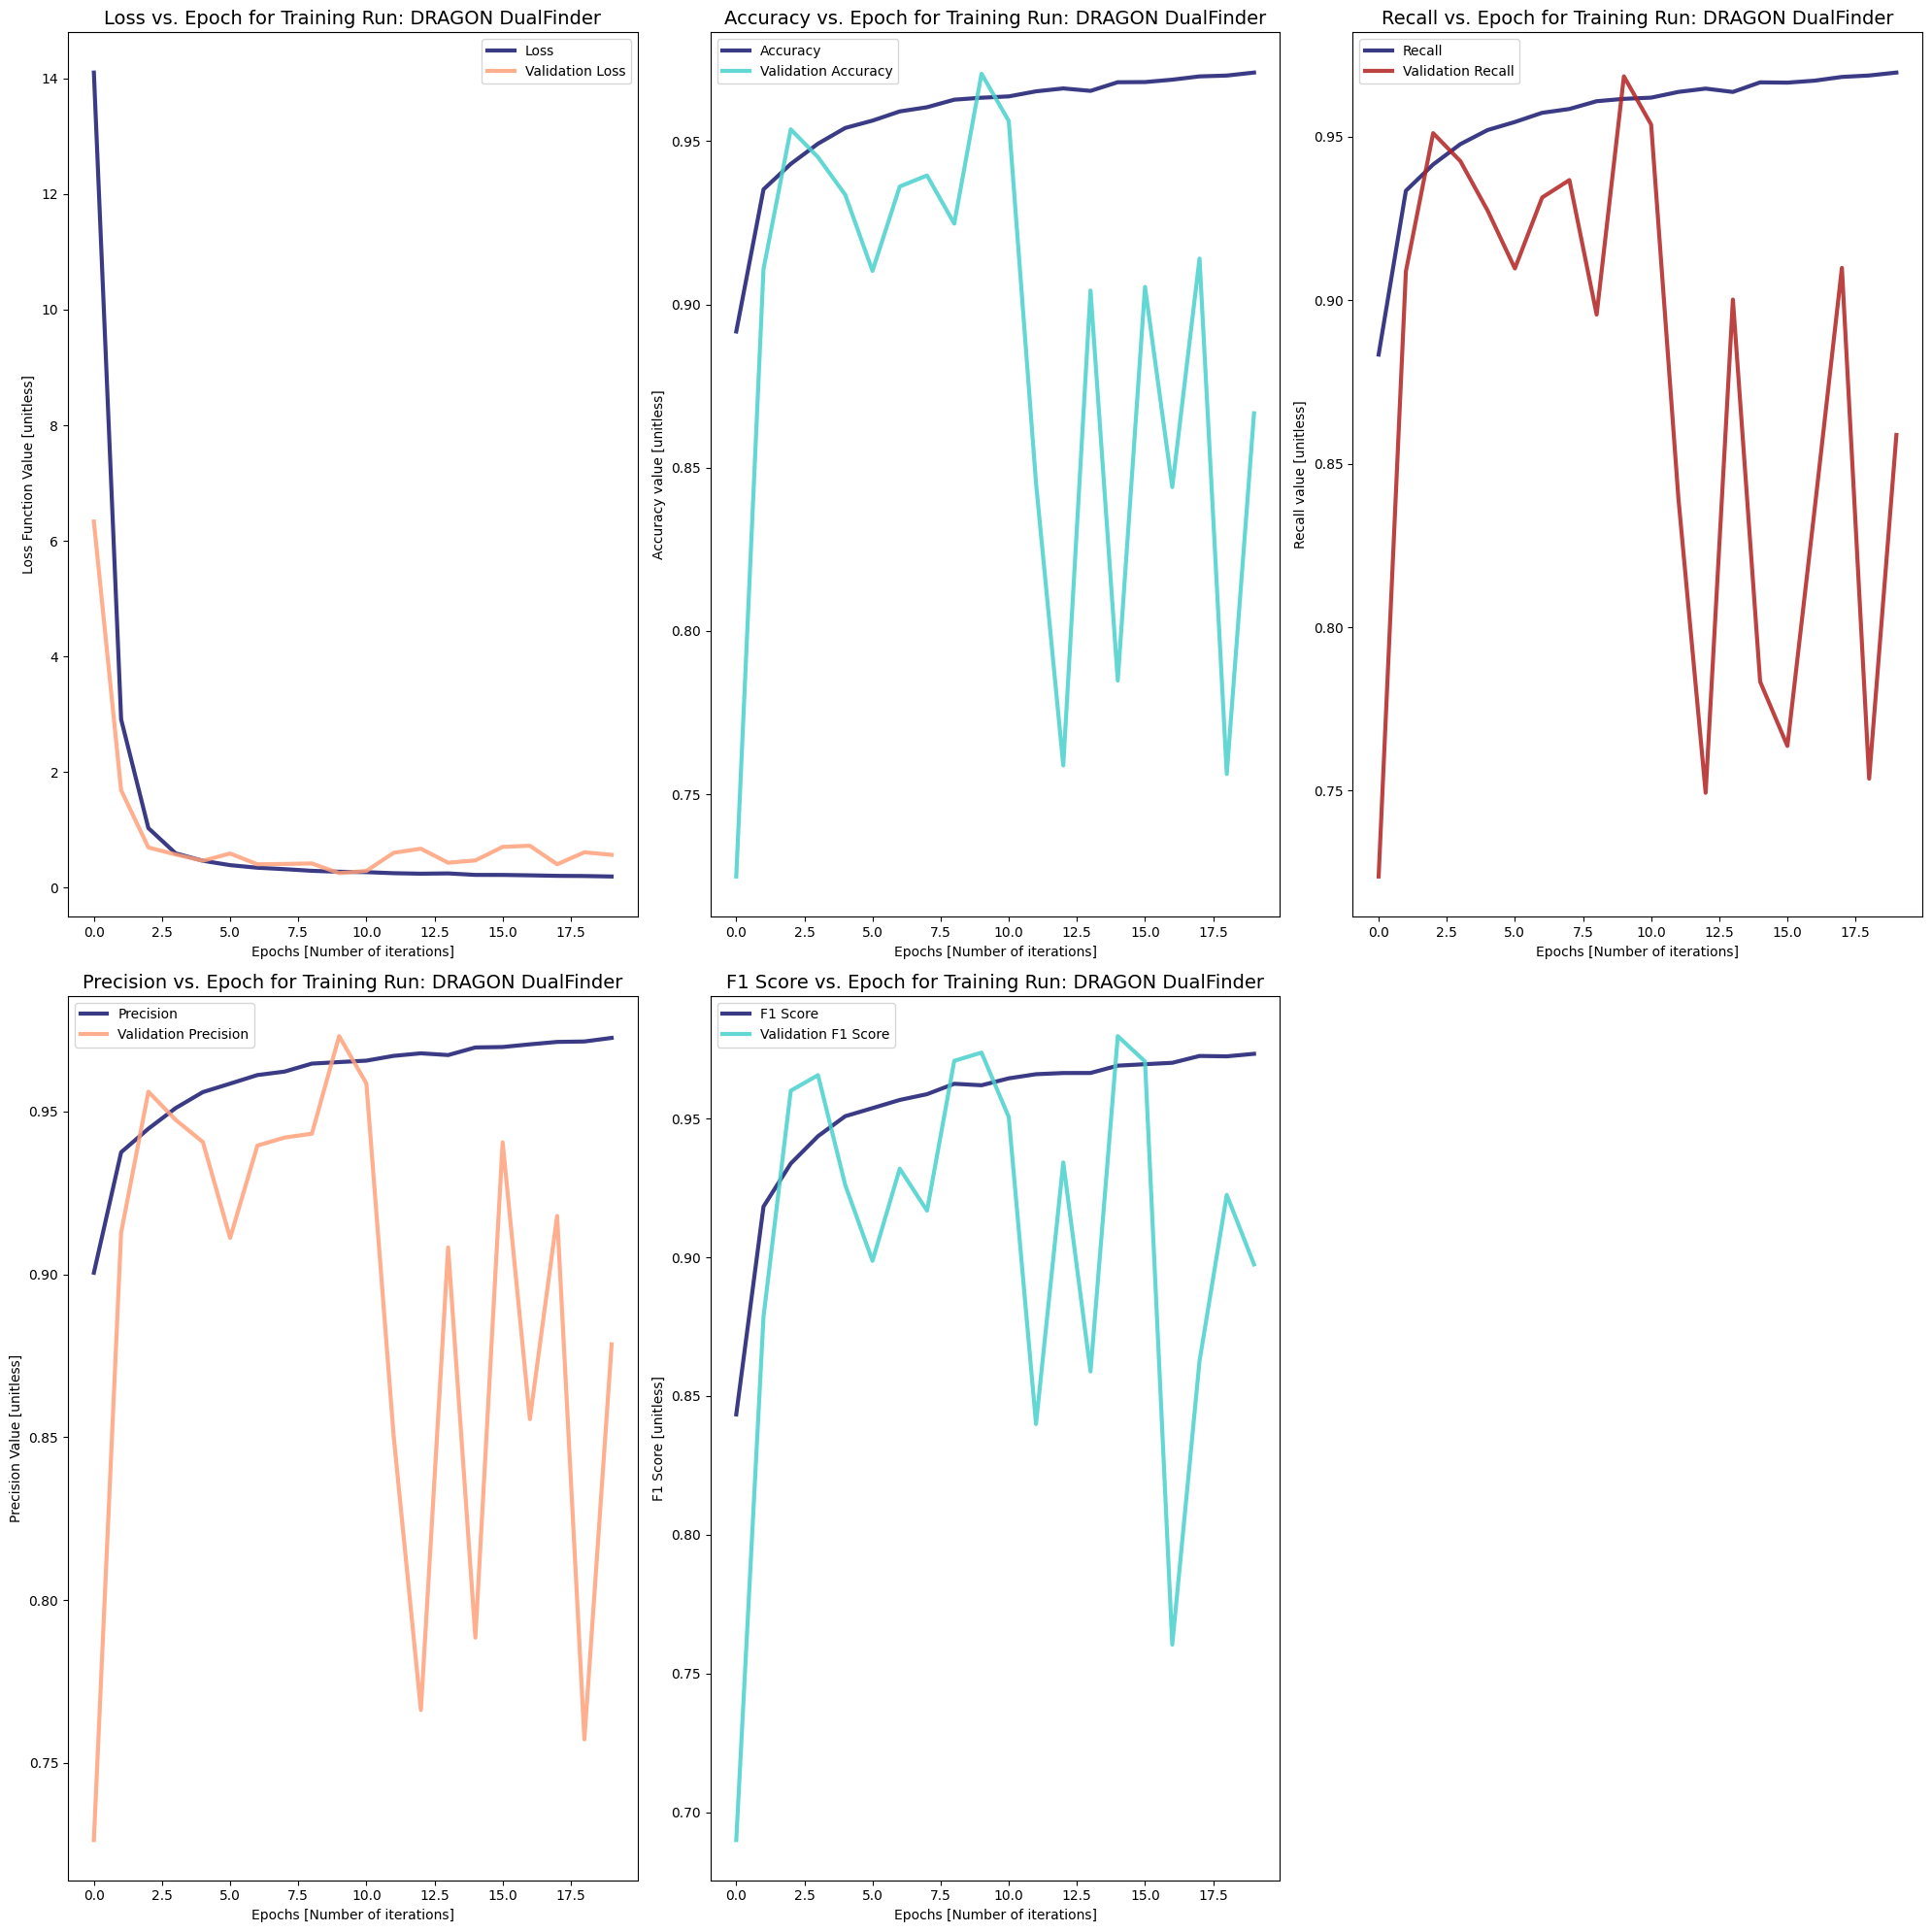

In [12]:
#print(history)
#print(type(history))
#print(history.history)
accuracy = history.history['accuracy']
loss = history.history['loss']
precision = history.history['precision']
recall = history.history['recall']
f1score = history.history['f1_score']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_f1score = history.history['val_f1_score']
training_epochs = np.arange(0, epoch)
fig_save_filepath = 'DRAGON_Dual_Finder/saved_training_figures/'
if not exists(fig_save_filepath):
    os.makedirs(fig_save_filepath)
fig, ax = plot_training_progress(loss, accuracy, training_epochs, save_filepath = fig_save_filepath, training_run = "DRAGON DualFinder",
                                 recall = recall, precision = precision, f1_score = f1score,
                                 val_loss = val_loss, val_acc = val_accuracy, val_recall = val_recall, val_precision = val_precision, 
                                 val_f1_score = val_f1score)

In [13]:
eval_labels_encoded, _ = dual_finder_instance.encode_labels(test_labels, test_labels)
dual_finder_model.evaluate(test_dataset, eval_labels_encoded, batch_size = batch_size, verbose = 1)

['dual_AGN' 'empty_sky' 'dual_AGN' ... 'dual_AGN' 'single_AGN' 'dual_AGN']
['dual_AGN' 'empty_sky' 'dual_AGN' ... 'dual_AGN' 'single_AGN' 'dual_AGN']
Converting to list
Converting to list
424/424 [==============================] - 6s 11ms/step - loss: 0.5692 - accuracy: 0.8636 - precision: 0.8752 - recall: 0.8555 - f1_score: 0.8696


[0.5691654682159424,
 0.8636095523834229,
 0.8752121329307556,
 0.8554998636245728,
 array([0.94169736, 0.90123004, 0.7730969 , 0.8625019 ], dtype=float32)]

In [19]:
len("data_preprocessing/training_datasets/")

37

In [33]:
test_images = []
test_image_names = []
for ii, image_file in tqdm(enumerate(glob.glob("hsc_2626_test_HSC-G/*.fits"))):
    try:
        with fits.open(image_file, memmap=False) as hdul:
            img = hdul[1].data
            img = crop_center(img, 94, 94)
            test_images.append(img)
            test_image_names.append(image_file)
    except OSError:
        print(f"file {image_file} has become corrupted.")
test_images = np.expand_dims(test_images, axis = -1)
print(test_images.shape)
test_instance = testResults(test_images, test_image_names, "hsc_2626_test_HSC-G/")
test_instance.test(dual_finder_model)

2624it [00:03, 790.41it/s]


(2624, 94, 94, 1)
82/82 [==============================] - 0s 4ms/step


2624it [00:02, 957.98it/s] 

object_ID     hsc_2626_test_HSC-G/QSO_220811_56_023830_1.fits
label                                              single_AGN
confidence                                           0.900347
Name: 642, dtype: object
object_ID     hsc_2626_test_HSC-G/UNK_220718_43_001723_1.fits
label                                                  merger
confidence                                           0.799859
Name: 2434, dtype: object
object_ID     hsc_2626_test_HSC-G/UNK_220906_91_004543_9.fits
label                                                  merger
confidence                                           0.713334
Name: 2460, dtype: object
object_ID     hsc_2626_test_HSC-G/UNK_221115_06_000030_9.fits
label                                                  merger
confidence                                           0.601222
Name: 2499, dtype: object
Number of double AGN:  24
Number of single AGN:  2600


[{'label': 'single_AGN', 'confidence': 0.9994592},
 {'label': 'single_AGN', 'confidence': 0.99987626},
 {'label': 'single_AGN', 'confidence': 0.9998784},
 {'label': 'single_AGN', 'confidence': 0.92237544},
 {'label': 'single_AGN', 'confidence': 0.9997236},
 {'label': 'single_AGN', 'confidence': 0.9990927},
 {'label': 'single_AGN', 'confidence': 0.9973871},
 {'label': 'dual_AGN', 'confidence': 0.93109196},
 {'label': 'single_AGN', 'confidence': 0.9998807},
 {'label': 'single_AGN', 'confidence': 0.999889},
 {'label': 'single_AGN', 'confidence': 0.99964046},
 {'label': 'single_AGN', 'confidence': 0.9995883},
 {'label': 'single_AGN', 'confidence': 0.9998759},
 {'label': 'single_AGN', 'confidence': 0.99618214},
 {'label': 'single_AGN', 'confidence': 0.99969804},
 {'label': 'single_AGN', 'confidence': 0.99980766},
 {'label': 'single_AGN', 'confidence': 0.99987257},
 {'label': 'single_AGN', 'confidence': 0.99969065},
 {'label': 'single_AGN', 'confidence': 0.9990645},
 {'label': 'single_AGN', 

663/663 [==============================] - 6s 9ms/step
data_preprocessing/training_datasets/dual_AGN_datasets/train_data/ with predicted label: dual_AGN and confidence: 0.998773992061615
data_preprocessing/training_datasets/dual_AGN_datasets/train_data with predicted label: dual_AGN and confidence: 0.999946117401123
data_preprocessing/training_datasets/dual_AGN_datasets/train_data with predicted label: dual_AGN and confidence: 0.9999219179153442
data_preprocessing/training_datasets/dual_AGN_datasets/train_data with predicted label: single_AGN and confidence: 0.9174101948738098
data_preprocessing/training_datasets/stellar_dataset/train_data/ with predicted label: star_AGN_align and confidence: 0.9997784495353699
data_preprocessing/training_datasets/offset_AGN_datasets/train_data/ with predicted label: offset_AGN and confidence: 0.9999986886978149
data_preprocessing/training_datasets/offset_AGN_datasets/train_data/1 with predicted label: offset_AGN and confidence: 0.9999105930328369
data

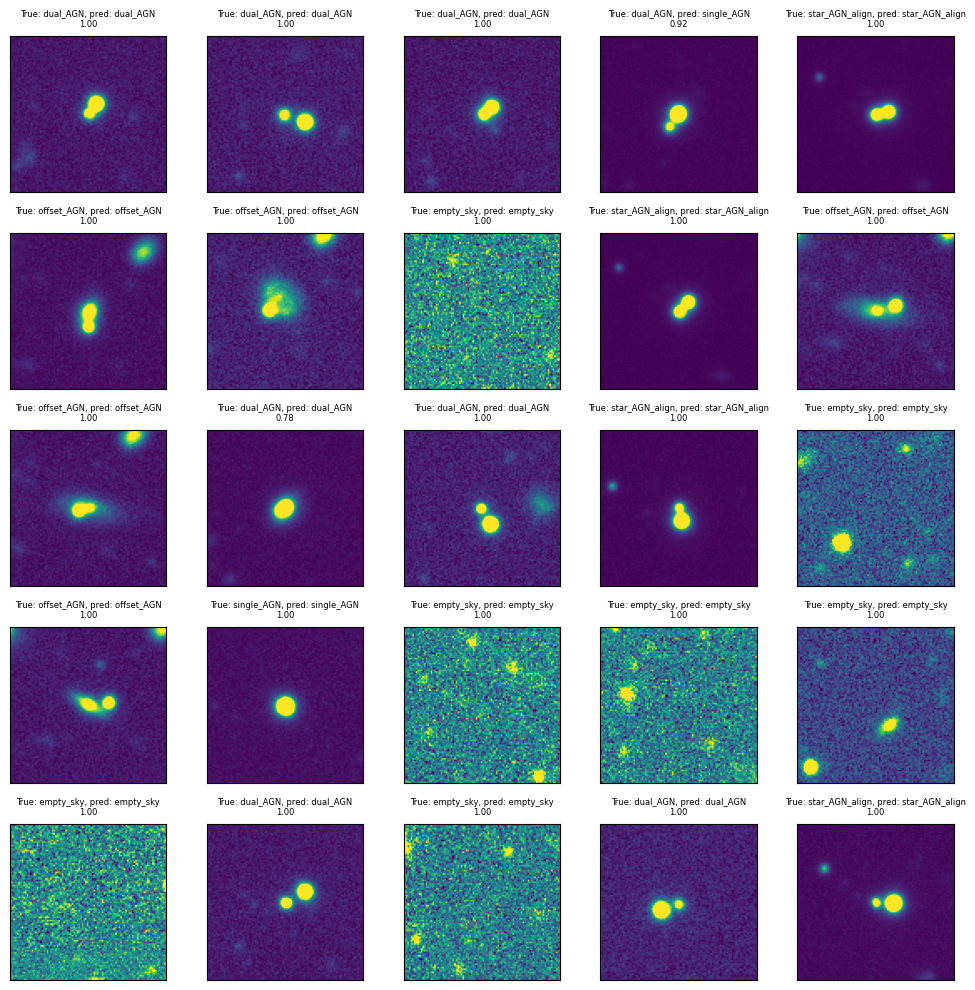

In [21]:
dual_finder_instance.predict(dual_finder_model, test_dataset, test_filepaths, test_labels)